<h1>Verkeerssimulatie: Het experiment.</h1>

De implementatie van zowel het Nagel-Schreckenbergmodel, als het model geïntroduceerd in Tian et al. (1996) zijn geïmplementeerd in de "trafficsim/lib/sim" Python package. Het daadwerkelijk uitvoeren van de simulatie, welke parameters daarvoor gebruikt worden, en hoe de resulterende data verwerkt wordt word in deze Jupyter Notebook gedaan, zodat dat dit extra inzichtelijk is. Hierbij word echter alleen gefocussed op de daadwerkelijke stappen die genomen worden om de data te verkrijgen en verwerken. De design-filosofie en uitgebreidere intrepetatie van de resultaten worden in het hoofddocument gedaan.

Dit document begint met de implementatie van het Nagel-Schreckenbergmodel in de meest klassieke vorm (1-baansweg) en de resultaten daarvan. Daarna word het 2-banen model hetzelfde benaderd. Onze hypothese is gevormd om een bepaald kantelpunt, waarvan we de locatie zullen bekijken als derde onderdeel.

<h3>1-baans</h3>

We beginnen door een aantal libraries te importeren.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from mesa.batchrunner import BatchRunner

import trafficsim

In het model zit een willikeurig element, namelijk het willikeurig afremmen van verkeersdeelnemers. Om alsnog valide conclusies uit de simulatie te kunnen trekken voeren we deze meerdere keren uit, met behulp van de 'BatchRunner' die in Mesa ingebouwd zit. We beginnen met het 'standaard' 1-rijbaan model. We variëren de willikeurige kans om af te remmen, en de dichtheid van autos.


We werken met een rijbaanlengte van 50 'cellen'.

In [2]:
LANE_LENGTH = 50
MAX_VELOCITY = 5

In [3]:
variable_params = {"agents_n": np.arange(1, LANE_LENGTH, 2),
                   "p_brake": np.linspace(0, 1, 10, endpoint=False)}

In [4]:
fixed_params = {"lane_length": LANE_LENGTH,
                "max_velocity": MAX_VELOCITY}

In [5]:
batch_runner_1 = BatchRunner(
    trafficsim.OneLaneRoad,
    variable_parameters=variable_params,
    fixed_parameters=fixed_params,
    iterations=50,
    max_steps=50,
    model_reporters={
        "Data Collector": lambda m: m.data_collector  # Grab the data collector from every run.
    }
)

batch_runner_1.run_all()

12500it [01:48, 114.88it/s]


In [6]:
df_1 = batch_runner_1.get_model_vars_dataframe()
df_1

,agents_n,p_brake,Run,Data Collector,lane_length,max_velocity
0,1,0.0,0,<mesa.datacollection.DataCollector object at 0...,50,5
1,1,0.0,1,<mesa.datacollection.DataCollector object at 0...,50,5
2,1,0.0,2,<mesa.datacollection.DataCollector object at 0...,50,5
3,1,0.0,3,<mesa.datacollection.DataCollector object at 0...,50,5
4,1,0.0,4,<mesa.datacollection.DataCollector object at 0...,50,5
...,...,...,...,...,...,...
12495,49,0.9,12495,<mesa.datacollection.DataCollector object at 0...,50,5
12496,49,0.9,12496,<mesa.datacollection.DataCollector object at 0...,50,5
12497,49,0.9,12497,<mesa.datacollection.DataCollector object at 0...,50,5
12498,49,0.9,12498,<mesa.datacollection.DataCollector object at 0...,50,5


Bij elke keer dat het expiriment is uitgevoerd is een <i>Data Collector</i> opgeslagen. De informatie over de gemiddelde snelheid op elke tijdstap in dat expiriment kan daar uit gehaald worden, en gebruikt worden om een gemiddelde snelheid voor die uitvoeringen te bepalen. Hiervoor nemen we alle tijdstappen vanaf t = 5 mee, zodat alle autos de mogelijkheid hebben gehad de maximale snelheid te bereiken mits er niets in hun weg is.

In [7]:
velocities = df_1["Data Collector"].apply(lambda d: d.get_model_vars_dataframe())

In [8]:
df_1["Average velocity"] = velocities.apply(lambda s: s[MAX_VELOCITY:].mean())

In [9]:
df_1.head(5)

,agents_n,p_brake,Run,Data Collector,lane_length,max_velocity,Average velocity
0,1,0.0,0,<mesa.datacollection.DataCollector object at 0...,50,5,5.0
1,1,0.0,1,<mesa.datacollection.DataCollector object at 0...,50,5,5.0
2,1,0.0,2,<mesa.datacollection.DataCollector object at 0...,50,5,5.0
3,1,0.0,3,<mesa.datacollection.DataCollector object at 0...,50,5,5.0
4,1,0.0,4,<mesa.datacollection.DataCollector object at 0...,50,5,5.0


Om de onderzoeksvraag op een valide manier te kunnen beantwoorden, is het handig de hoeveelheid agents in de simulatie om te zetten naar een dichtheid.

In [10]:
df_1["Density"] = df_1["agents_n"] / LANE_LENGTH

Vervolgens kunnen we voor elke permutatie van de variabele parameters (de hoeveelheid agents in de simulatie, en de kans om elke tijdstap willikeurig af te remmen) het gemidddeld van alle geobserveerde gemiddelde snelheden over alle herhalingen van dezelfde instellingen.

In [11]:
df_1_grouped = df_1.groupby(["Density", "p_brake"]).mean()["Average velocity"]
df_1_grouped

Density  p_brake
0.02     0.0        5.000000
         0.1        4.878222
         0.2        4.766222
         0.3        4.641333
         0.4        4.516000
                      ...   
0.98     0.5        0.010485
         0.6        0.008200
         0.7        0.005977
         0.8        0.004263
         0.9        0.002023
Name: Average velocity, Length: 250, dtype: float64

Vervolgens kunnen we de verschillende waardes voor elke instelling van p_brake de gemiddelde snelheid per dichtheid laten zien.

Text(0, 0.5, 'Gemiddelde snelheid (cellen per tijdseenheid)')

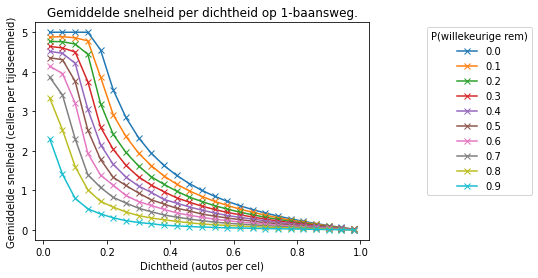

In [32]:
fig, ax = plt.subplots()

for p in variable_params["p_brake"]:
    ax.plot(df_1_grouped[(slice(None), p)], "x-", label=round(p, 2))

ax.legend(
    title="P(willekeurige rem)",
    bbox_to_anchor=(1.5, 1)
)
ax.set_title("Gemiddelde snelheid per dichtheid op 1-baansweg.")
ax.set_xlabel("Dichtheid (autos per cel)")
ax.set_ylabel("Gemiddelde snelheid (cellen per tijdseenheid)")

Onze hypothese lijkt inderdaad kloppend in het feit dat er een kantelpunt is, waarna de dichtheid van het verkeerd een negatief effect heeft op de doorstroom.

<h3>2-Baans</h3>

Om een realistischer element aan de simulatie toe te voegen, en te kunnen kijken of dat van invloed is op de loop van filevorming kunnen we ook kijken naar wegen met 2 rijstroken. Om dit te onderzoeken kunnen we dezelfde stappen als eerder ondernemen. Omdat we op deze weg bij dezelfde lengte 2 keer zoveel cellen krijgen, passen we de hoeveelheden autos aan om te testen.

In [13]:
variable_params_2 = variable_params
variable_params_2["agents_n"] = np.arange(1, LANE_LENGTH * 2, 4)

We voeren het expiriment wederom uit.

In [14]:
batch_runner_2 = BatchRunner(
    trafficsim.TwoLaneRoad,
    variable_parameters=variable_params_2,
    fixed_parameters=fixed_params,
    iterations=50,
    max_steps=50,
    model_reporters={
        "Data Collector": lambda m: m.data_collector  # Grab the data collector from every run.
    }
)

batch_runner_2.run_all()

12500it [04:33, 45.64it/s]


We halen hier de datacollectors uit, welke we vervolgens gebruiken om de gemiddelde snelheden per uitvoering van het expiriment te bepalen.

In [15]:
df_2 = batch_runner_2.get_model_vars_dataframe()
velocities_2 = df_2["Data Collector"].apply(lambda d: d.get_model_vars_dataframe())
df_2["Average velocity"] = velocities_2.apply(lambda s: s[MAX_VELOCITY:].mean())

We rekenen de hoeveelheid agents om naar dichtheid.

In [16]:
df_2["Density"] = df_2["agents_n"] / (LANE_LENGTH * 2)

En rekenen per permutatie van de instellingen de gemiddeldes uit, en beelden deze af in een grafiek.

In [17]:
df_2_grouped = df_2.groupby(["Density", "p_brake"]).mean()["Average velocity"]
df_2_grouped

Density  p_brake
0.01     0.0        5.000000
         0.1        4.888444
         0.2        4.768889
         0.3        4.649333
         0.4        4.451556
                      ...   
0.97     0.5        0.015817
         0.6        0.012591
         0.7        0.009526
         0.8        0.006080
         0.9        0.003033
Name: Average velocity, Length: 250, dtype: float64

Text(0, 0.5, 'Gemiddelde snelheid (cellen per tijdseenheid)')

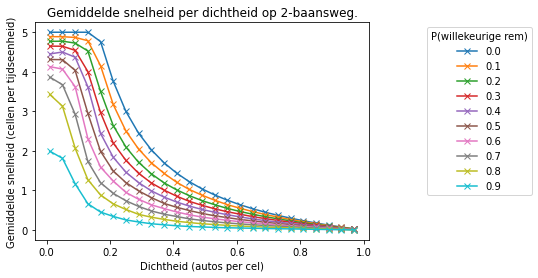

In [33]:
fig, ax = plt.subplots()

for p in variable_params_2["p_brake"]:
    ax.plot(df_2_grouped[(slice(None), p)], "x-", label=round(p, 2))

ax.legend(
    title="P(willekeurige rem)",
    bbox_to_anchor=(1.5, 1)
)
ax.set_title("Gemiddelde snelheid per dichtheid op 2-baansweg.")
ax.set_xlabel("Dichtheid (autos per cel)")
ax.set_ylabel("Gemiddelde snelheid (cellen per tijdseenheid)")

In dit geval lijkt de hypothese stand te houden. Zelfs lijkt de dichtheid waarop het kantelpunt van dichtheid waarna dit doorstroom negatief begint te beïnvloeden op hetzelfde punt te liggen. De doorstroomg valt echter minder snel na dit punt, dan bij het scenario met 1 baan. TODO(m-jeu): IS dit waar?

<h3>Kantelpunt</h3>

Het is duidelijk dat er een kantelpunt is waarna de dichtheid op een weg de doorstroom begint in te vloeden in het Nagel-Schreckenbergmodel. Eisenblätter et al. (1998) stelt dat dit ontstaat als functie van de maximale snelheid:

$$ρ(Vmax) = \frac{1}{1 + Vmax}$$

Om dit te doen kunnen we de simulatie een aantal keer uitvoeren, met 10 verschillende maximale snelheden. De kans om willikeurig af te remmen is in dit geval op 0 vastgezet, omdat de gestelde formule alleen relevant is voor de situatie waar willikeurig afremmen niet gebeurt. Zonder willikeurig element kunnen we veilig elke individuele instellingspermutatie één keer uitvoeren.

We werken met een langere weg, zodat de discrete stappen in dichtheid kleiner kunnen zijn.

In [19]:
LONG_LANE_LENGTH = 250

In [20]:
variable_params_3 = {
    "max_velocity": np.arange(1, 11),
    "agents_n": np.arange(1, LONG_LANE_LENGTH)
}

In [21]:
fixed_params_3 = {"lane_length": LONG_LANE_LENGTH,
                  "p_brake": 0}

In [22]:
batch_runner_3 = BatchRunner(
    trafficsim.OneLaneRoad,
    variable_parameters=variable_params_3,
    fixed_parameters=fixed_params_3,
    max_steps=100,
    model_reporters={
        "Data Collector": lambda m: m.data_collector  # Grab the data collector from every run.
    }
)

batch_runner_3.run_all()

2490it [02:21, 17.60it/s]


Wederom nemen we van elke uitvoering van het model de gemiddelde snelheid op een bepaald punt.

In [23]:
df_3 = batch_runner_3.get_model_vars_dataframe()
df_3["Velocities"] = df_3["Data Collector"].apply(lambda d: d.get_model_vars_dataframe())

Om het gemiddelde vanaf het punt dat alle autos tijd hebben gehad (wanneer zij niet geblokkeerd worden) uit te kunnen rekenen, moeten we dit keer rekening houden wat de maximum snelheid op in die uitvoering van het model was.

We nemen het gemiddelde van alle snelheden bijbehorend bij een bepaalde uitvoering van het model, vanaf de <i>maximum snelheid</i>-ste tijdstap.

In [24]:
df_3["Average velocity"] = df_3[["Velocities", "max_velocity"]].apply(
    lambda row: (row["Velocities"][row["max_velocity"]:]).mean(),
    axis=1  # Voer lambda uit op elke rij.
)

We voeren elke permutatie van mogelijke instellingen maar één keer uit. We hoeven dus geen <i>groupby</i> operatie te doen.

We willen wel nog de hoeveelheid agents omrekenen naar een dichtheid.

In [25]:
df_3["Density"] = df_3["agents_n"] / LONG_LANE_LENGTH

Wanneer het kantelpunt van dichtheid nog niet bereikt is, verwacht men dat de gemiddelde snelheid gelijk is aan (of dichtbij is, vanwege floating-point math) de maximale snelheid. We kunnen het kantelpunt dan ook opzoeken door te zoeken naar het punt waar dit voor het eerst niet bijna gelijk aan elkaar is, en het laatste punt waar dit wel zo is.

In [26]:
delta = .0001

# Boolean mask that represents whether average and max velocity are within delta of each other.
not_equal_mask = np.abs(df_3["Average velocity"] - df_3["max_velocity"]) > delta

In [27]:
# Lowest density at which max_velocity and average velocity are not within delta of eachother for every max velocity.
upper_bound = df_3[not_equal_mask].groupby("max_velocity").agg({
    "Density": np.min
})

upper_bound

,Density
max_velocity,
1,0.504
2,0.336
3,0.252
4,0.204
5,0.168
6,0.144
7,0.128
8,0.112
9,0.104


In [28]:
# Highest density at which max_velocity and average velocity are within delta of eachother for every max velocity.
lower_bound = df_3[~not_equal_mask].groupby("max_velocity").agg({
    "Density": np.max
})

lower_bound

,Density
max_velocity,
1,0.500
2,0.332
3,0.248
4,0.200
5,0.164
6,0.140
7,0.124
8,0.108
9,0.100


Omdat we met discrete waarnemingen werken, zou het punt waarop de dichtheid de gemiddelde snelheid begint te beïnvloeden tussen de 2 berekende punten moeten liggen bij elke maximale waarde.

We kunnen deze geobserveerde, samen met de formule plotten in een grafiek om deze te vergelijken.

Text(0, 0.5, 'Dichtheid bij kantelpunt')

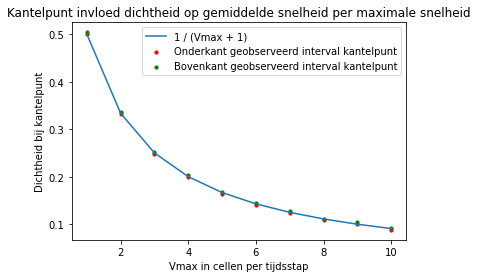

In [29]:
fig, ax = plt.subplots()
ax.plot(lower_bound.index, 1 / (1 + lower_bound.index), label="1 / (Vmax + 1)")
ax.scatter(lower_bound.index, lower_bound, c="r", s=10, label="Onderkant geobserveerd interval kantelpunt")
ax.scatter(upper_bound.index, upper_bound, c="g", s=10, label="Bovenkant geobserveerd interval kantelpunt")
ax.legend()
ax.set_title("Kantelpunt invloed dichtheid op gemiddelde snelheid per maximale snelheid")
ax.set_xlabel("Vmax in cellen per tijdsstap")
ax.set_ylabel("Dichtheid bij kantelpunt")

De volledige referenties zijn te vinden in het verslag.